In [111]:
import pandas as pd
import numpy as np
import cianparser
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

class Data_Loader():
    def __init__(self):
        self.region = "Москва"
        self.date = []
        self.df = pd.DataFrame()
        self.file_name = 'Cian_flat_sale_' + self.region
        
    def load_data(self):
        print("Загружаю даные")
        region_parser = cianparser.CianParser(location = self.region)
        self.data = region_parser.get_flats(deal_type="sale", rooms=(1, 2), with_saving_csv=True, additional_settings={"start_page":1, "end_page":3})
        self.df = pd.DataFrame(self.data)
        return
        
    def save_xls(self):
        if len(self.df) == 0 :
            print("Необходимо загрузит данные")
        else:
            print(f'Запись в файл {self.file_name}.xls')
            self.df.to_excel(f'{self.file_name}.xlsx')
        return

    def save_db(self):
        if len(self.df) == 0 :
            print("Необходимо загрузит данные")
        else:
            conn = sqlite3.connect(f'{self.file_name}.db')
            self.df.to_sql('cian_' + self.region, conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
        return
            
    def save_pkl(self):
        if len(self.df) == 0 :
            print("Необходимо загрузит данные")
        else:
            print(f'Запись в файл {self.file_name}.pkl' )
            self.df.to_pickle(f'{self.file_name}.pkl')
        return
        
class Stat_Builder():
    
    def __init__(self, data_file):
        self.data_file = data_file
        df = pd.read_csv(self.data_file, sep = ';')
        df = df.loc[df['price'] != 0]
        df_f = df.groupby('district').count()[['author']].reset_index()
        self.df_f = df_f.loc[df_f['author'] >= 20]
        self.df_sts = df.loc[df['district'].isin(self.df_f['district'])]
        self.df_sts = self.df_sts.copy()
        self.df_sts['price'] = self.df_sts['price']/1000000
        # Добавим столбец - цена за  комнату 
        self.df_sts['price_room'] = self.df_sts['price']/self.df_sts['rooms_count']
        # Добавим столбец - цена за 1 кв.метр
        self.df_sts['price_kvm'] = self.df_sts['price']/self.df_sts['total_meters']
    
    def diag_1(self):
        rcParams['figure.figsize'] = 6,6
        colors = sns.color_palette('pastel')[0:5]
        plt.pie(self.df_f['author'], labels = self.df_f['district'],
                colors = colors, pctdistance=0.8, radius = 1.5, autopct = '%.02f%%')
        plt.show()
    
    def diag_2(self):
        df_1 = self.df_sts[['district','price_room']].groupby('district').mean()
        df_1 = df_1.reset_index()
        df_1['price_room'] = df_1['price_room']
        df_1 = df_1.set_index('district')['price_room']
        rcParams['figure.figsize'] = 13,8
        df_1.sort_values(ascending = False).plot(kind='bar',
                                                title = 'Средняя цена за комнату по районам',
                                                ylabel = 'млн.руб.',
                                                xlabel = 'Районы')
        plt.show()

    def diag_3(self):
        df_2 = self.df_sts[['district','price_kvm']].groupby('district').mean()
        df_2 = df_2.reset_index()
        df_2['price_kvm'] = df_2['price_kvm']
        df_2 = df_2.set_index('district')['price_kvm']
        rcParams['figure.figsize'] = 13,8
        df_2.plot(kind='bar',
                  title = 'Средняя цена за квадратный метр по районам',
                  ylabel = 'млн.руб.',
                  xlabel = 'Районы')
    plt.show()
    
    def diag_4(self):
        sns.relplot(x = 'district',
                y = self.df_sts['price_kvm'],
                data = self.df_sts,
                kind = 'line',
                height = 6,
                aspect = 2
                )
        plt.title('Разброс цен от средней цены за кв.м.')
        plt.xticks(rotation = 90)
        plt.ylabel('млн.руб.')
        plt.xlabel('Районы')
        plt.show()

    def diag_5(self):
        sns.relplot(x = 'district',
            y = self.df_sts['price_room'],
            data = self.df_sts,
            kind = 'line',
            height = 6,
            aspect = 2
            )
        plt.title('Разброс цен от средней цены за 1 комнату')
        plt.ylabel('млн.руб.')
        plt.xlabel('Районы')
        plt.xticks(rotation = 90)
        plt.show()

    def diag_6(self):
        sns.set(rc = {'figure.figsize':(10,6)})
        sns.relplot(x = 'district',
                    y = 'price_room',
                    hue = 'rooms_count',
                    data = self.df_sts,
                    kind = 'scatter',
                    height = 6,
                    aspect = 2
                    )
        plt.title('Распределение цены за 1 комнату')
        plt.ylabel('млн.руб.')
        plt.xlabel('Районы')
        plt.xticks(rotation = 90)
        plt.show()

    def diag_7(self):
        sns.relplot(x = 'district',
                    y = 'price_kvm',
                    hue = 'rooms_count',
                    data = self.df_sts,
                    kind = 'scatter',
                    height = 6,
                    aspect = 2
                    )
        plt.title('Распределение цены за кв.м.')
        plt.xticks(rotation = 90)
        plt.ylabel('млн.руб.')
        plt.xlabel('Районы')
        plt.show()
        
    def diag_8(self):
        sns.catplot(x = 'district',
                    y = 'price_kvm',
                    hue = 'rooms_count',
                    data = self.df_sts,
                    kind = 'box',
                    height = 6,
                    aspect = 2
                    )
        plt.title('Распределение цены за кв.м.')
        plt.xticks(rotation = 90)
        plt.ylabel('млн.руб.')
        plt.xlabel('Районы')
        plt.show()
        
    def diag_9(self):
        sns.catplot(x = 'district',
                    y = 'price_kvm',
                    hue = 'rooms_count',
                    data = self.df_sts,
                    kind = 'violin',
#             split=True,
#             inner="stick",
#             palette="pastel",
                    height = 6,
                    aspect = 2,
                    )
        plt.title('Распределение цены за кв.м.')
        plt.xticks(rotation = 90)
        plt.ylabel('млн.руб.')
        plt.xlabel('Районы')
        plt.show()
    

In [52]:
# ..\cian_flat_sale_1_50_moskva_16_Jul_2024_21_54_28_310895.csv

dat = Data_Loader()

In [55]:
dat.save_xls()

Запись в файл Cian_flat_sale_Москва.xls


In [112]:
my_sts = Stat_Builder(r'C:\Users\Mitrich\Documents\Repository_1\HomeWork_2\cian_flat_sale_1_50_moskva_16_Jul_2024_21_54_28_310895.csv')

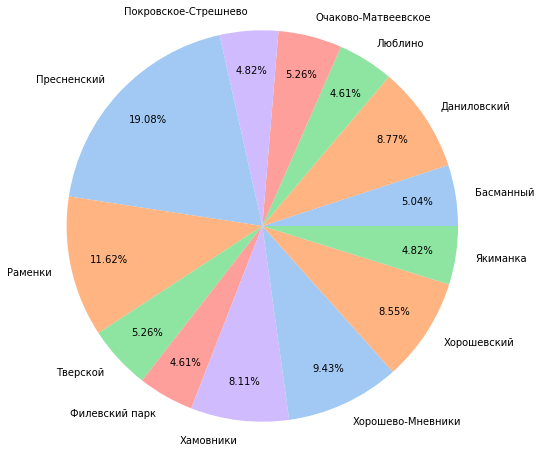

In [113]:
my_sts.diag_1()

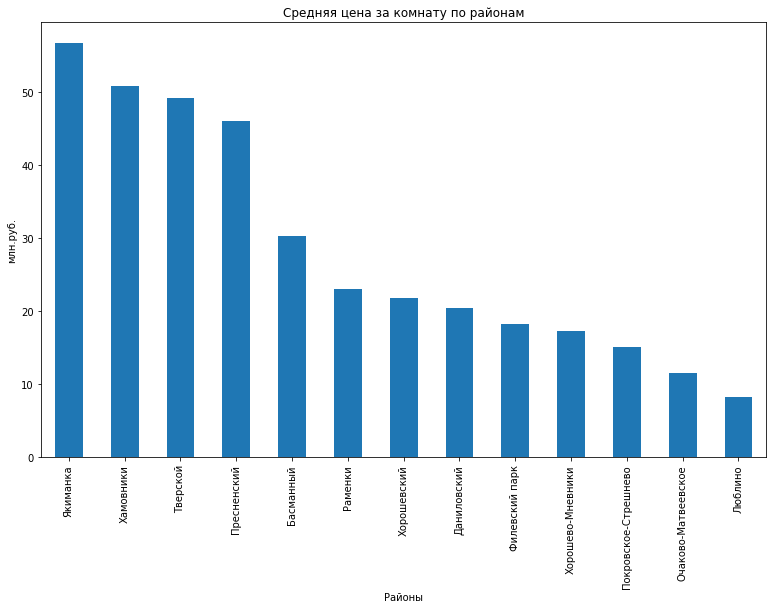

In [114]:
my_sts.diag_2()

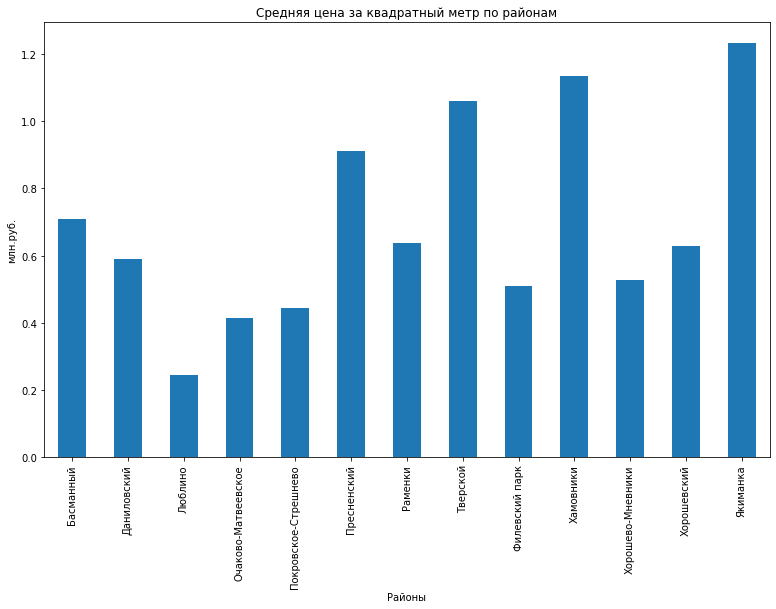

In [115]:
my_sts.diag_3()

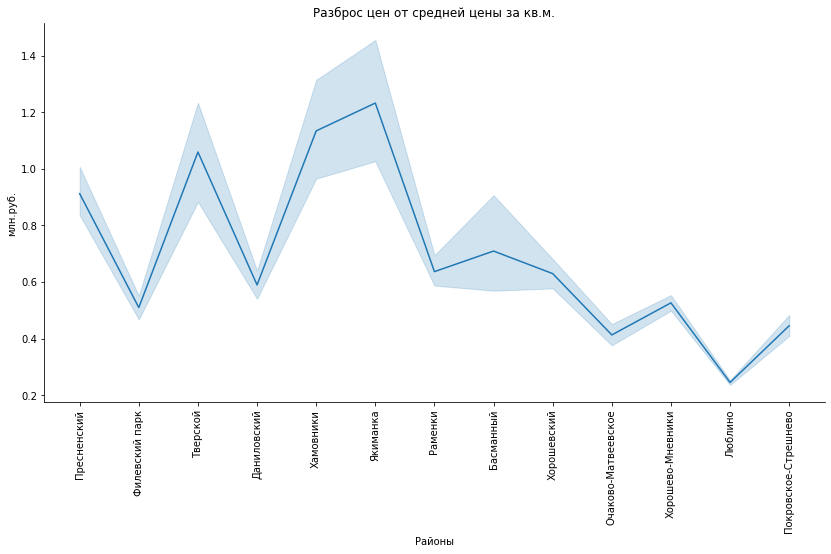

In [116]:
my_sts.diag_4()

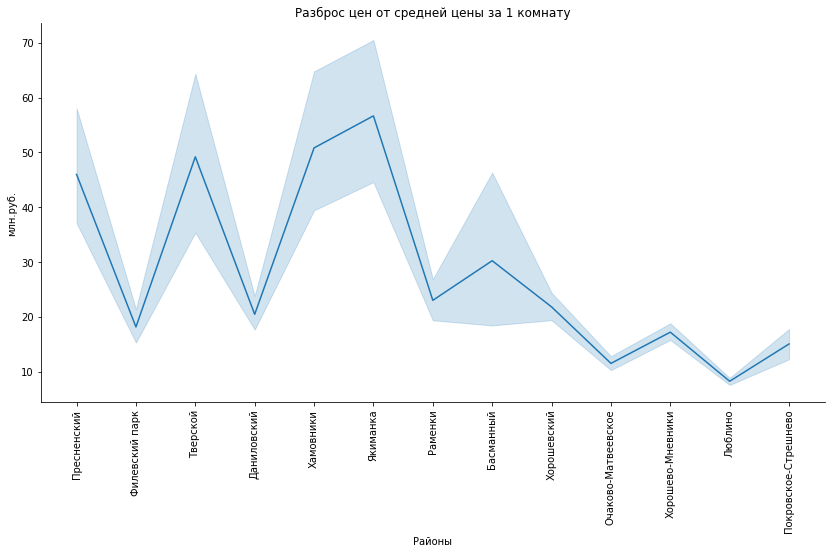

In [117]:
my_sts.diag_5()

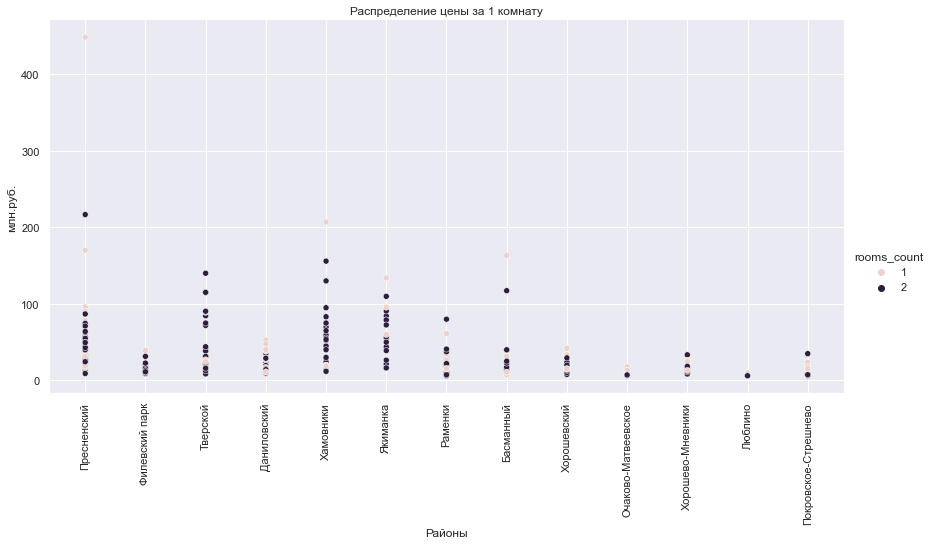

In [118]:
my_sts.diag_6()

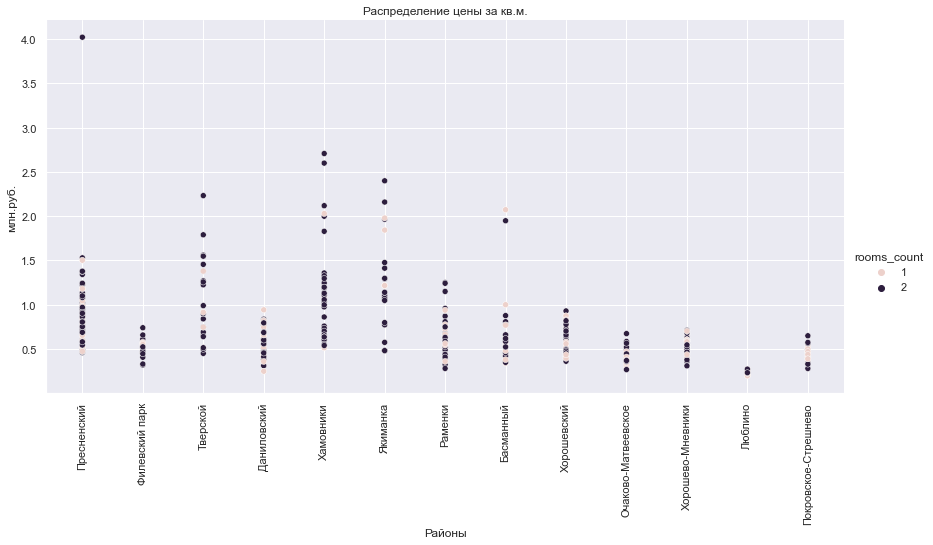

In [119]:
my_sts.diag_7()

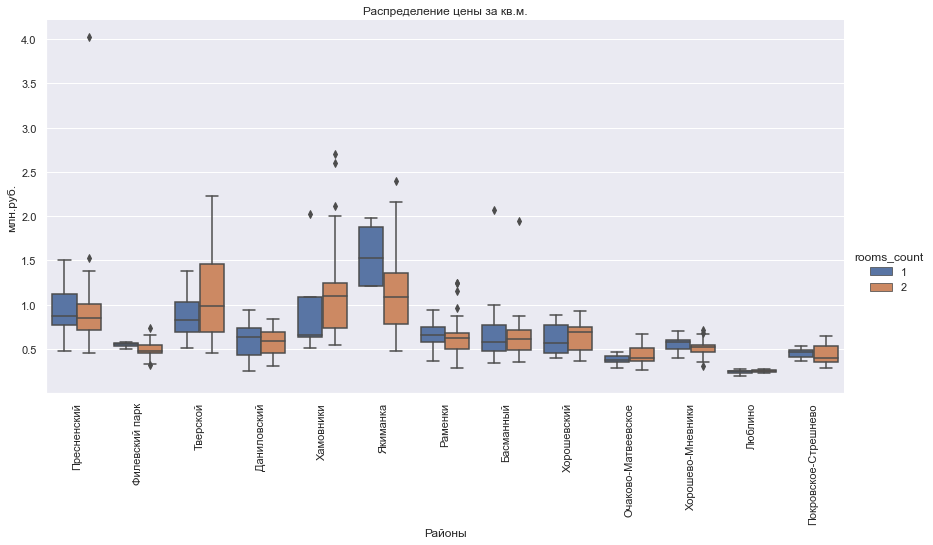

In [120]:
my_sts.diag_8()

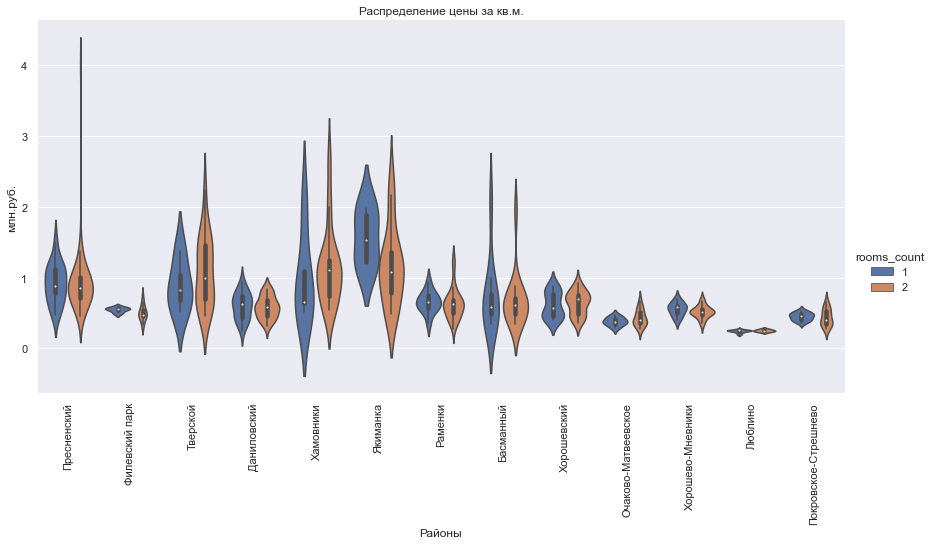

In [121]:
my_sts.diag_9()